In [1]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
aer_sim = Aer.get_backend('aer_simulator')

In [2]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [3]:
noise_model = get_noise(0.01,0.01)

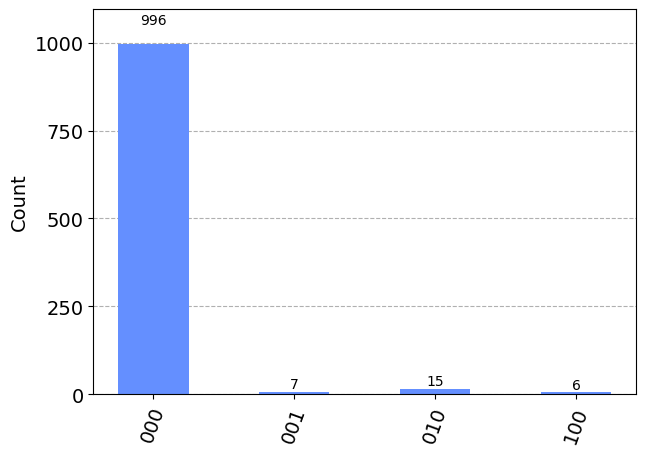

In [4]:
qc0 = QuantumCircuit(3) # initialize circuit with three qubits in the 0 state
qc0.measure_all() # measure the qubits

# run the circuit with the noise model and extract the counts
qobj = assemble(qc0)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

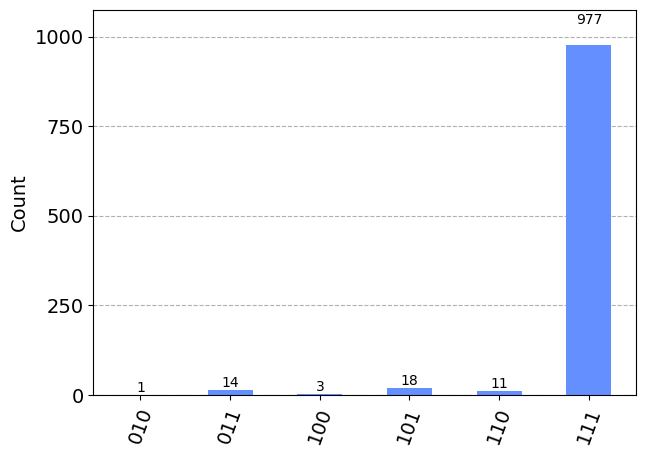

In [5]:
qc1 = QuantumCircuit(3) # initialize circuit with three qubits in the 0 state
qc1.x([0,1,2]) # flip each 0 to 1

qc1.measure_all() # measure the qubits

# run the circuit with th noise model and extract the counts
qobj = assemble(qc1)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

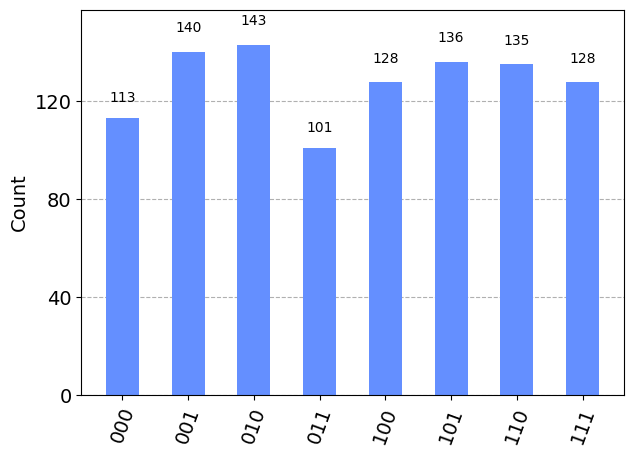

In [6]:
noise_model = get_noise(0.5,0.0)
qobj = assemble(qc1)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

In [7]:
cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'auxiliary_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

code_qubit_0: ──■──────────
                   │          
   code_qubit_1: ──┼────■─────
                 ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ┤ X ├┤ X ├┤M├
                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════╩═
                            0

In [9]:
qc_init = QuantumCircuit(cq)

qobj = assemble(qc.compose(qc_init, front=True))
counts = aer_sim.run(qobj).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


In [10]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])
qc_init.x(cq[0])
qc.compose(qc_init, front=True).draw()

┌───┐     ┌───┐             
   code_qubit_0: ┤ H ├──■──┤ X ├──■──────────
                 └───┘┌─┴─┐└───┘  │          
   code_qubit_1: ─────┤ X ├───────┼────■─────
                      └───┘     ┌─┴─┐┌─┴─┐┌─┐
auxiliary_qubit: ───────────────┤ X ├┤ X ├┤M├
                                └───┘└───┘└╥┘
 syndrome_bit: 1/══════════════════════════╩═
                                           0

In [11]:
qobj = assemble(qc.compose(qc_init, front=True))
counts = aer_sim.run(qobj).result().get_counts()
print('Results:',counts)

Results: {'1': 1024}


In [12]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

In [13]:
n = 3
T = 1
code = RepetitionCode(n, T)

In [14]:
code.circuit['0'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ┤ X ├─────┤ X ├────────┤M├─────────
                    └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ──┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                      │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ──■────┼────┼────┼──┤M├─╫──╫───────
                           │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ───────■────■────┼───╫──╫──╫─┤M├───
                                     │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ─────────────────■───╫──╫──╫──╫─┤M├
                                         ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/═════════════════════╬══╩══╩══╬══╬═
                                         ║  0  1  ║  ║ 
        code_bit: 3/═════════════════════╩════════╩══╩═
                                         0        1  2

In [15]:
code.circuit['0'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ┤ X ├─────┤ X ├────────┤M├─────────
                    └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ──┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                      │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ──■────┼────┼────┼──┤M├─╫──╫───────
                           │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ───────■────■────┼───╫──╫──╫─┤M├───
                                     │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ─────────────────■───╫──╫──╫──╫─┤M├
                                         ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/═════════════════════╬══╩══╩══╬══╬═
                                         ║  0  1  ║  ║ 
        code_bit: 3/═════════════════════╩════════╩══╩═
                                         0        1  2

In [16]:
def get_raw_results(code,noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        qobj = assemble(circuits[log])
        job = aer_sim.run(qobj, noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log, ':', raw_results[log], '\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



In [17]:
code = RepetitionCode(n,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'000 00 00 00 00': 1024} 

Logical 1 : {'111 00 00 00 00': 1024} 



In [18]:
code = RepetitionCode(5,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'00000 0000 0000 0000 0000': 1024} 

Logical 1 : {'11111 0000 0000 0000 0000': 1024} 



In [19]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'010 00': 51, '110 01': 3, '000 00': 678, '001 00': 45, '010 01': 26, '000 01': 68, '100 11': 1, '001 01': 5, '000 10': 57, '100 00': 41, '110 00': 7, '000 11': 7, '100 01': 7, '101 00': 3, '011 00': 2, '010 10': 5, '100 10': 6, '001 10': 5, '010 11': 4, '101 10': 1, '111 00': 1, '011 11': 1} 

Logical 1 : {'111 00': 595, '011 00': 44, '111 10': 66, '111 01': 69, '011 10': 16, '101 00': 71, '110 00': 54, '110 01': 16, '101 01': 22, '110 11': 3, '101 11': 16, '001 00': 1, '011 01': 8, '011 11': 5, '110 10': 7, '100 10': 1, '010 10': 1, '111 11': 4, '010 00': 3, '101 10': 3, '100 00': 3, '100 11': 3, '100 01': 4, '010 01': 4, '001 11': 1, '001 10': 2, '000 01': 1, '010 11': 1} 



In [20]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    qobj = assemble(circuits[log], shots=10000)
    job = aer_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

In [21]:
P = lookuptable_decoding(table_results,raw_results)
print('P =',P)

P = {'0': 0.0185546875, '1': 0.0205078125}


In [22]:
code = RepetitionCode(3,2)

raw_results = get_raw_results(code,noise_model)

results = code.process_results( raw_results )

for log in ['0','1']:
    print('\nLogical ' + log + ':')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 00 00': 496, '000 01 00': 50, '000 10 00': 58, '000 00 10': 60}
processed results  {'0 0  00 00 00': 496, '0 0  00 01 01': 50, '0 0  00 10 10': 58, '0 0  10 10 00': 60}

Logical 1:
raw results        {'111 00 00': 454, '111 01 00': 50}
processed results  {'1 1  00 00 00': 454, '1 1  00 01 01': 50}


In [23]:
step_2 = False
step_3 = False

In [24]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.tools import job_monitor

In [25]:
device_name = 'ibmq_16_melbourne'

if step_2 or step_3:
    
    IBMQ.load_account()
    
    for provider in IBMQ.providers():
        for potential_backend in provider.backends():
            if potential_backend.name()==device_name:
                backend = potential_backend

    coupling_map = backend.configuration().coupling_map

In [26]:
if device_name=='ibmq_16_melbourne':
    line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]
elif device_name=='ibmq_rochester':
    line = [10,11,17,23,22,21,20,19,16,7,8,9,5]#,0,1,2,3,4,6,13,14,15,18,27,26,25,29,36,37,38,41,50,49,48,47,46,45,44,43,42,39,30,31]

In [27]:
n_min = 3
n_max = int((len(line)+1)/2)

code = {}

for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

In [28]:
def get_initial_layout(code,line,n):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

In [29]:
if step_2:
    circuits = []
    for n in range(n_min,n_max+1):
        initial_layout = get_initial_layout(code[n],line,n)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log], backend=backend, initial_layout=initial_layout) )
            num_cx = dict(circuits[-1].count_ops())['cx']
            assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

In [30]:
if step_2:
    # run all the circuits
    job = backend.run(circuits, shots=8192)
    job_monitor(job)

    # organize the results of the run
    raw_results = {}
    j = 0
    for d in range(n_min,n_max+1):
        raw_results[d] = {}
        for log in ['0','1']:
            raw_results[d][log] = job.result().get_counts(j)
            j += 1

In [31]:
if step_2: # save results
    with open('results/raw_results_'+device_name+'.txt', 'w') as file:
        file.write(str(raw_results))
elif step_3: # read results
    with open('results/raw_results_'+device_name+'.txt', 'r') as file:
        raw_results = eval(file.read())

In [32]:
if step_3:
    results = {}
    for n in range(n_min,n_max+1):
        results[n] = code[n].process_results( raw_results[n] )

In [33]:
if step_3:
    dec = {}
    for n in range(n_min,n_max+1):
        dec[n] = GraphDecoder(code[n])

In [34]:
if step_3:
    logical_prob_match = {}
    for n in range(n_min,n_max+1):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])
        
    with open('results/logical_prob_match_'+device_name+'.txt', 'w') as file:
        file.write(str(logical_prob_match))
        
else:
    with open('results/logical_prob_match_'+device_name+'.txt', 'r') as file:
        logical_prob_match = eval(file.read())

FileNotFoundError: [Errno 2] No such file or directory: 'results/logical_prob_match_ibmq_16_melbourne.txt'

In [35]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = range(n_min,n_max+1)
P = { log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1'] }

ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter( x_axis, P['0'], label="logical 0")
ax.scatter( x_axis, P['1'], label="logical 1")
ax.set_yscale('log')
ax.set_ylim(ymax=1.5*max(P['0']+P['1']),ymin=0.75*min(P['0']+P['1']))
plt.legend()
plt.show()

NameError: name 'logical_prob_match' is not defined

In [36]:
if step_3:

    dec[n_max].weight_syndrome_graph(results=results[n_max])

    probs = []
    for edge in dec[n_max].S.edges:
        ratio = np.exp(-dec[n_max].S.get_edge_data(edge[0],edge[1])['distance'])
        probs.append( ratio/(1+ratio) )
        
    with open('results/probs_'+device_name+'.txt', 'w') as file:
        file.write(str(probs))
        
else:
    
    with open('results/probs_'+device_name+'.txt', 'r') as file:
        probs = eval(file.read())

FileNotFoundError: [Errno 2] No such file or directory: 'results/probs_ibmq_16_melbourne.txt'